In [ ]:
#Boundary detection using LSTM

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont
import arabic_reshaper
from bidi.algorithm import get_display

from collections import deque

import psutil
import time

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model - Loads the model that detects body/hands
mp_drawing = mp.solutions.drawing_utils # Drawing utilities - # Helps draw the detected points

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable - saves a little bit to memory
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(255,255,250), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=2)
                             ) 

In [7]:
sequence_dir = './keypoints' 

In [8]:
#Sequence-length 30 

In [9]:
sequence_length = 30

features_30 = [] 
labels_30 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_30.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length]
                    features_30.append(truncated_sequence)
                    
                labels_30.append(word_folder) 

In [43]:
X_30 = np.array(features_30)

print("X_30 shape:", X_30.shape)

X_30 shape: (8437, 30, 258)


In [44]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_30 = label_encoder.fit_transform(labels_30)
y_30 = np.array(y_30)
y_30

array([ 0,  0,  0, ..., 19, 19, 19])

In [45]:
X30_train, X30_test, y30_train, y30_test = train_test_split(X_30, y_30, test_size=0.2, random_state=42,stratify=y_30)

In [ ]:
#Model 1: LSTM with Masking Layer sequence-length 30

In [46]:
LSTM_30Masking_model = Sequential()
LSTM_30Masking_model.add(Masking(mask_value=0., input_shape=(30, X30_train.shape[2])))
LSTM_30Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_30Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_30Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_30Masking_model.add(Dense(64, activation='relu'))
LSTM_30Masking_model.add(Dense(32, activation='relu'))
LSTM_30Masking_model.add(Dense(20, activation='softmax')) # 14 classes

LSTM_30Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_30Masking_model.summary()

C:\Users\walid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 30, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,812 (928.95 KB)

 Trainable params: 237,812 (928.95 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model_save_path = 'LSTM_30Masking_model20.keras' 

checkpoint_callback = ModelCheckpoint('LSTM_30Masking_model_checkpoint.keras', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_30Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_30Masking_model.fit(X30_train, y30_train, validation_data=(X30_test, y30_test), epochs=70, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_30Masking_model.save(model_save_path)

Epoch 1/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.0525 - loss: 3.0026 - val_accuracy: 0.0835 - val_loss: 3.0050
Epoch 2/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.0708 - loss: 2.8485 - val_accuracy: 0.1605 - val_loss: 2.4392
Epoch 3/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1756 - loss: 2.2997 - val_accuracy: 0.2447 - val_loss: 2.0598
Epoch 4/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2782 - loss: 1.9820 - val_accuracy: 0.3412 - val_loss: 1.7475
Epoch 5/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3326 - loss: 1.7750 - val_accuracy: 0.3916 - val_loss: 1.5683
Epoch 6/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3766 - loss: 1.6072 - val_accuracy: 0.3898 - val_loss: 1.5795
Epoch 7/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.4599 - loss: 1.4473 - val_accuracy: 0.4502 - val_loss: 1.3922
Epoch 8/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.4797 - loss: 1.3581 - val_acc

In [ ]:
#Evaluation-30 with masking

In [47]:
LSTM_30Masking_model20 = load_model('LSTM_30Masking_model20.keras')

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


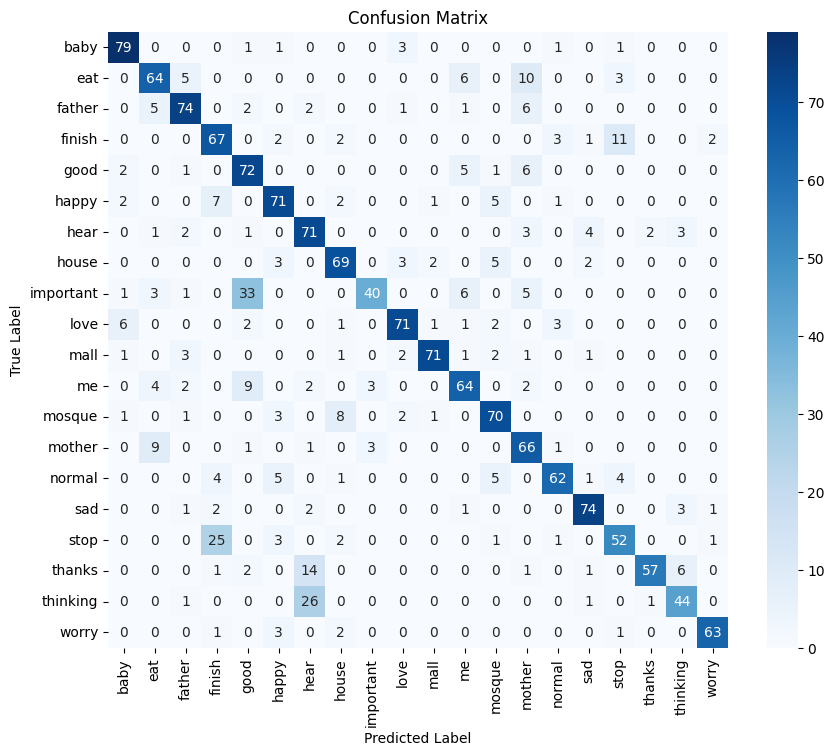

In [48]:
# Make predictions on the validation set
y30_pred_prob = LSTM_30Masking_model20.predict(X30_test)

# Convert predicted probabilities to class labels
y30_pred = np.argmax(y30_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y30_test, y30_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Evaluate the model on the test data
evaluation = LSTM_30Masking_model20.evaluate(X30_test, y30_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7635 - loss: 0.6607
Accuracy: 77.07346081733704 %


In [ ]:
#Sequence-length 35

In [50]:
# Define the desired sequence length
sequence_length_35 = 35

features_35 = [] 
labels_35 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_35:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_35 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_35.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_35]
                    features_35.append(truncated_sequence)
                    
                labels_35.append(word_folder) 

In [51]:
X_35 = np.array(features_35)

print("X_35 shape:", X_35.shape)

X_35 shape: (8437, 35, 258)


In [52]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_35 = label_encoder.fit_transform(labels_35)
y_35 = np.array(y_35)
y_35

array([ 0,  0,  0, ..., 19, 19, 19])

In [53]:
X35_train, X35_test, y35_train, y35_test = train_test_split(X_35, y_35, test_size=0.2, random_state=42,stratify=y_35)

In [ ]:
#Model 2: LSTM with Masking Layer sequence-length 35

In [54]:
LSTM_35Masking_model = Sequential()
LSTM_35Masking_model.add(Masking(mask_value=0., input_shape=(35, 258)))
LSTM_35Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_35Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_35Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_35Masking_model.add(Dense(64, activation='relu'))
LSTM_35Masking_model.add(Dense(32, activation='relu'))
LSTM_35Masking_model.add(Dense(20, activation='softmax')) # 14 classes

LSTM_35Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_35Masking_model.summary()

C:\Users\walid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 35, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 35, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 35, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,812 (928.95 KB)

 Trainable params: 237,812 (928.95 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model_save_path = 'LSTM_35Masking_model20.keras' 

checkpoint_callback = ModelCheckpoint('LSTM_35Masking_model_checkpoint.keras', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_35Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_35Masking_model.fit(X35_train, y35_train, validation_data=(X35_test, y35_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_35Masking_model.save(model_save_path)

Epoch 1/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.0753 - loss: 2.9808 - val_accuracy: 0.2079 - val_loss: 2.2190
Epoch 2/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2142 - loss: 2.1755 - val_accuracy: 0.3264 - val_loss: 1.8548
Epoch 3/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3431 - loss: 1.7739 - val_accuracy: 0.3857 - val_loss: 1.6158
Epoch 4/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.4275 - loss: 1.5323 - val_accuracy: 0.4520 - val_loss: 1.3572
Epoch 5/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5027 - loss: 1.2902 - val_accuracy: 0.5373 - val_loss: 1.1966
Epoch 6/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.5353 - loss: 1.2182 - val_accuracy: 0.5883 - val_loss: 1.0434
Epoch 7/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5793 - loss: 1.1039 - val_accuracy: 0.6060 - val_loss: 1.0045
Epoch 8/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6185 - loss: 0.9726 - val_acc

In [ ]:
Evaluation-35

In [55]:
LSTM_35Masking_model20 = load_model('LSTM_35Masking_model20.keras')

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


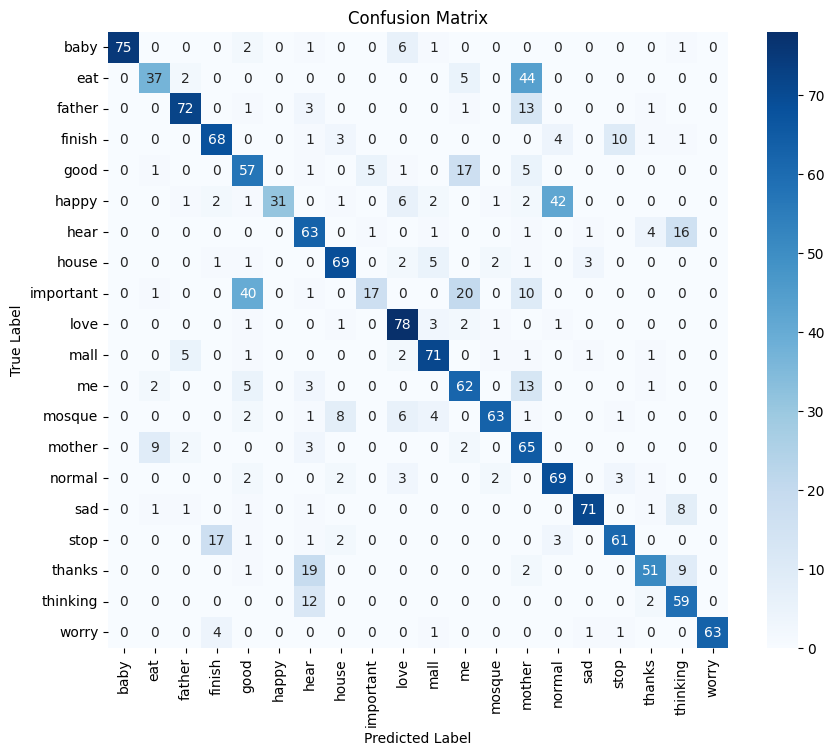

In [56]:
# Make predictions on the validation set
y35_pred_prob = LSTM_35Masking_model20.predict(X35_test)

# Convert predicted probabilities to class labels
y35_pred = np.argmax(y35_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y35_test, y35_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# Evaluate the model on the test data
evaluation = LSTM_35Masking_model20.evaluate(X35_test, y35_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7001 - loss: 0.8137
Accuracy: 71.20853066444397 %


In [ ]:
#Sequence-length 20

In [33]:
# Define the desired sequence length
sequence_length_20 = 20

features_20 = [] 
labels_20 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_20:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_20 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_20.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_20]
                    features_20.append(truncated_sequence)
                    
                labels_20.append(word_folder) 

In [34]:
X_20 = np.array(features_20)

print("X_20 shape:", X_20.shape)

X_20 shape: (8437, 20, 258)


In [35]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_20 = label_encoder.fit_transform(labels_20)
y_20 = np.array(y_20)
y_20

array([ 0,  0,  0, ..., 19, 19, 19])

In [36]:
X20_train, X20_test, y20_train, y20_test = train_test_split(X_20, y_20, test_size=0.2, random_state=42,stratify=y_20)

In [ ]:
#Model 3: LSTM with Masking Layer sequence-length 20

In [37]:
LSTM_20Masking_model = Sequential()
LSTM_20Masking_model.add(Masking(mask_value=0., input_shape=(20, 258)))
LSTM_20Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_20Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_20Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_20Masking_model.add(Dense(64, activation='relu'))
LSTM_20Masking_model.add(Dense(32, activation='relu'))
LSTM_20Masking_model.add(Dense(20, activation='softmax')) # 14 classes

LSTM_20Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_20Masking_model.summary()

C:\Users\walid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 20, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 20, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,812 (928.95 KB)

 Trainable params: 237,812 (928.95 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_save_path = 'LSTM_20Masking_model20.keras' 

checkpoint_callback = ModelCheckpoint('LSTM_20Masking_model_checkpoint.keras', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_20Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_20Masking_model.fit(X20_train, y20_train, validation_data=(X20_test, y20_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_20Masking_model.save(model_save_path)

Epoch 1/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.0653 - loss: 2.9743 - val_accuracy: 0.1072 - val_loss: 2.7420
Epoch 2/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1270 - loss: 2.5801 - val_accuracy: 0.1985 - val_loss: 2.2544
Epoch 3/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1974 - loss: 2.2287 - val_accuracy: 0.2553 - val_loss: 2.0473
Epoch 4/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2703 - loss: 1.9946 - val_accuracy: 0.3169 - val_loss: 1.8783
Epoch 5/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3156 - loss: 1.8758 - val_accuracy: 0.3128 - val_loss: 1.8579
Epoch 6/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3446 - loss: 1.7726 - val_accuracy: 0.3436 - val_loss: 1.8288
Epoch 7/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3651 - loss: 1.7703 - val_accuracy: 0.4028 - val_loss: 1.6677
Epoch 8/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4053 - loss: 1.6215 - val_acc

In [34]:
#Evaluation-20

NameError: name 'Evaluation' is not defined

In [38]:
LSTM_20Masking_model20 = load_model('LSTM_20Masking_model20.keras')

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


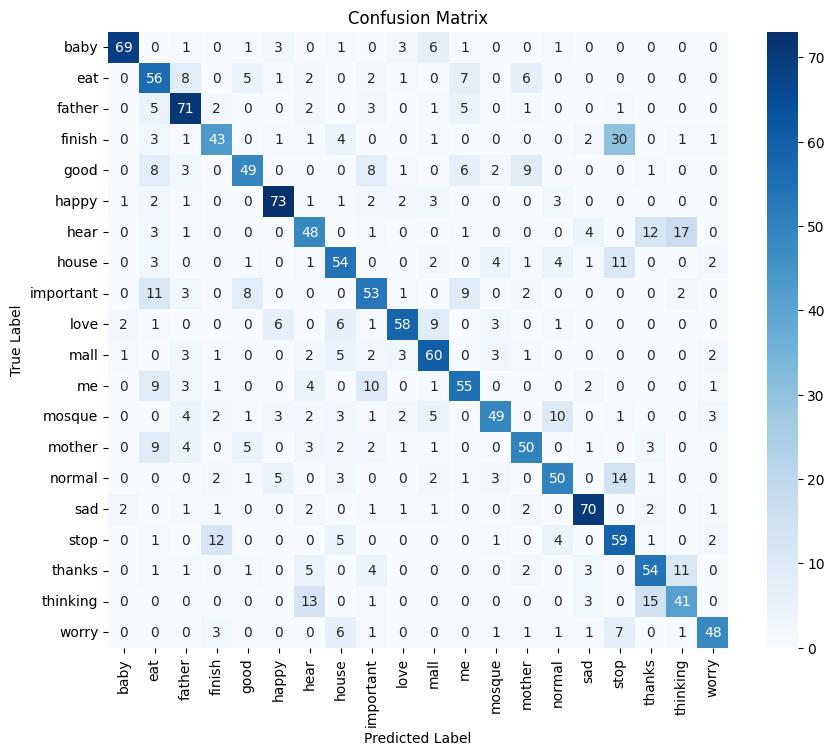

In [39]:
# Make predictions on the validation set
y20_pred_prob = LSTM_20Masking_model20.predict(X20_test)

# Convert predicted probabilities to class labels
y20_pred = np.argmax(y20_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y20_test, y20_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Evaluate the model on the test data
evaluation = LSTM_20Masking_model20.evaluate(X20_test, y20_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6632 - loss: 0.9658
Accuracy: 65.7582938671112 %


In [ ]:
#Sequence-length 40

In [15]:
# Define the desired sequence length
sequence_length_40 = 40

features_40 = [] 
labels_40 = []

for word_folder in os.listdir(sequence_dir):
    word_sequence_dir = os.path.join(sequence_dir, word_folder)
    if os.path.isdir(word_sequence_dir):
        for npy_file in os.listdir(word_sequence_dir):
            if npy_file.endswith('.npy'):
                npy_filepath = os.path.join(word_sequence_dir, npy_file)
                keypoints_sequence = np.load(npy_filepath)
                
                # Truncate or pad sequences to the desired length
                if len(keypoints_sequence) < sequence_length_40:
                    # Pad the sequence with zeros to reach the desired length
                    padding_length = sequence_length_40 - len(keypoints_sequence)
                    padded_sequence = np.pad(keypoints_sequence, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                    features_40.append(padded_sequence)
                else:
                    # Truncate the sequence to the desired length
                    truncated_sequence = keypoints_sequence[:sequence_length_40]
                    features_40.append(truncated_sequence)
                    
                labels_40.append(word_folder) 

In [16]:
X_40 = np.array(features_40)
print("X_40 shape:", X_40.shape)

X_40 shape: (8437, 40, 258)


In [17]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_40 = label_encoder.fit_transform(labels_40)
y_40 = np.array(y_40)
y_40

array([ 0,  0,  0, ..., 19, 19, 19])

In [18]:
X40_train, X40_test, y40_train, y40_test = train_test_split(X_40, y_40, test_size=0.2, random_state=42,stratify=y_40)

In [ ]:
#Model 4: LSTM with Masking Layer sequence-length 40

In [19]:
LSTM_40Masking_model = Sequential()
LSTM_40Masking_model.add(Masking(mask_value=0., input_shape=(40, 258)))
LSTM_40Masking_model.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_40Masking_model.add(LSTM(128, return_sequences=True, activation='relu'))
LSTM_40Masking_model.add(LSTM(64, return_sequences=False, activation='relu'))
LSTM_40Masking_model.add(Dense(64, activation='relu'))
LSTM_40Masking_model.add(Dense(32, activation='relu'))
LSTM_40Masking_model.add(Dense(20, activation='softmax')) # 14 classes

LSTM_40Masking_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_40Masking_model.summary()

C:\Users\walid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 40, 258)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,812 (928.95 KB)

 Trainable params: 237,812 (928.95 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_save_path = 'LSTM_40Masking_model20.keras' 

checkpoint_callback = ModelCheckpoint('LSTM_40Masking_model_checkpoint.keras', save_best_only=True)
early_stopping_callback = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join('Logs_LSTM_40Masking')
tb_callback = TensorBoard(log_dir=log_dir)

# Train the model with callbacks
LSTM_40Masking_model.fit(X40_train, y40_train, validation_data=(X40_test, y40_test), epochs=60, batch_size=32,
          callbacks=[checkpoint_callback, early_stopping_callback, tb_callback])

# Save the trained model
LSTM_40Masking_model.save(model_save_path)

Epoch 1/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.0860 - loss: 2.9631 - val_accuracy: 0.1854 - val_loss: 2.2771
Epoch 2/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2135 - loss: 2.1529 - val_accuracy: 0.2399 - val_loss: 2.1762
Epoch 3/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.3121 - loss: 1.8839 - val_accuracy: 0.4023 - val_loss: 1.5070
Epoch 4/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.3869 - loss: 1.6339 - val_accuracy: 0.4224 - val_loss: 1.5161
Epoch 5/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.4420 - loss: 1.4370 - val_accuracy: 0.5000 - val_loss: 1.2399
Epoch 6/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.3409 - loss: 1.9075 - val_accuracy: 0.4698 - val_loss: 1.3260
Epoch 7/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5216 - loss: 1.2580 - val_accuracy: 0.5948 - val_loss: 1.0711
Epoch 8/60
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5547 - loss: 1.1555 - val_acc

In [ ]:
#Evaluation-40

In [25]:
from tensorflow.keras.models import load_model

# Load the saved model
LSTM_40Masking_model20 = load_model('LSTM_40Masking_model20.keras')




53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


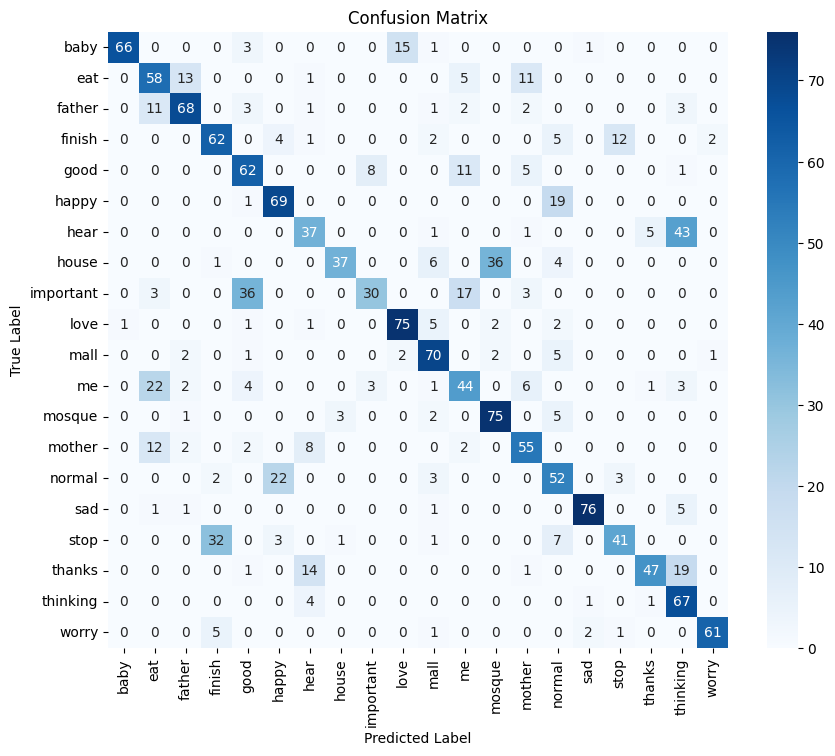

In [26]:
# Make predictions on the validation set
# Then use it to make predictions
y40_pred_prob = LSTM_40Masking_model20.predict(X40_test)

# Convert predicted probabilities to class labels
y40_pred = np.argmax(y40_pred_prob, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y40_test, y40_pred)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [58]:
# Evaluate the model on the test data
evaluation = LSTM_40Masking_model20.evaluate(X40_test, y40_test)
accuracy = evaluation[1]
accuracy_percentage = accuracy * 100
print("Accuracy:", accuracy_percentage, "%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6829 - loss: 0.8593
Accuracy: 68.24644804000854 %


In [10]:
label_encoder = LabelEncoder()
# Fit label encoder and transform labels to integers
y_30_encoded = label_encoder.fit_transform(labels_30)

# Get the unique classes (words) and their corresponding encoded indices
word_indices = {index: word for index, word in enumerate(label_encoder.classes_)}

print("Index to Word Mapping:")
for index, word in word_indices.items():
    print(f"Index: {index}, Word: {word}")

Index to Word Mapping:
Index: 0, Word: baby
Index: 1, Word: eat
Index: 2, Word: father
Index: 3, Word: finish
Index: 4, Word: good
Index: 5, Word: happy
Index: 6, Word: hear
Index: 7, Word: house
Index: 8, Word: important
Index: 9, Word: love
Index: 10, Word: mall
Index: 11, Word: me
Index: 12, Word: mosque
Index: 13, Word: mother
Index: 14, Word: normal
Index: 15, Word: sad
Index: 16, Word: stop
Index: 17, Word: thanks
Index: 18, Word: thinking
Index: 19, Word: worry


In [11]:
english_to_arabic = {
    "baby":"طفل",
    "eat": "يأكل",
    "father": "أب", 
    "finish": "ينهي", 
    "good": "جيد", 
    "happy":"سعيد", 
    "hear": "يسمع",
    "house": "بيت",
    "important": "مهم",
    "love": "يحب",
    "mall": "مول",
    "me": "أنا",
    "mosque": "مسجد",
    "mother": "أم",
    "normal": "عادي",
    "sad": "حزين", 
    "stop": "توقف", 
    "thanks": "شكرا ",
    "thinking": "يفكر",
    "worry": "قلق",
}

def convert_to_arabic(english_word):
    return english_to_arabic.get(english_word, english_word)

In [12]:
loaded_30_model = load_model('LSTM_30Masking_model20.keras')
loaded_35_model = load_model('LSTM_35Masking_model20.keras')
loaded_20_model = load_model('LSTM_20Masking_model20.keras')
loaded_40_model = load_model('LSTM_40Masking_model20.keras')

In [ ]:
#Model30+35+40 - Three-LSTM Model

In [22]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 = 0.0
confidence_35 = 0.0
confidence_40 = 0.0
model_label = ""
predicted_word = ""

video_path = "My_Videos/z/video1.mp4"  # Replace with your video file path
cap = cv2.VideoCapture(video_path)  # Changed from cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_35 = loaded_35_model.predict(np.expand_dims(sequence[:35], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_35 = np.argmax(res_35)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_35 = res_35[predicted_index_35]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_35 and confidence_30 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 1: 30 frames"
            elif confidence_35 >= confidence_30 and confidence_35 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_35, "Unknown")
                unused_frames = sequence[35:]  # Unused frames for the next sequence
                confidence = confidence_35
                model_label = "Model 2: 35 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
                print("Final text output:", full_sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            # Adjusted text positions for rotated image (assuming width is now height)
            draw.text((50, 50), bidi_text, font=font, fill=(0, 0, 0))  # Black text
            draw.text((50, 80), confidence_text, font=font, fill=(0, 0, 0))
            draw.text((50, 120), model_label_text, font=font, fill=(0, 0, 0))           
            image = np.array(img_pil)
            
        # Show the output image
        cv2.imshow('Model30+35+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Final text output: أم
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Final text output: أم ينهي
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Final text output: أم ينهي توقف
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Final text output: أم ينهي توقف مول
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [54]:
# Initialize variables
sequence = []  # Use list to keep track of frames
sentence = []
threshold = 0.5
confidence_30 =0.0
confidence_35 =0.0
confidence_40 =0.0
model_label = ""
predicted_word=""


cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Add keypoints to the sequence
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        
        # Once the sequence reaches length 40
        if len(sequence) == 40:
            res_30 = loaded_30_model.predict(np.expand_dims(sequence[:30], axis=0))[0]
            res_35 = loaded_35_model.predict(np.expand_dims(sequence[:35], axis=0))[0]
            res_40 = loaded_40_model.predict(np.expand_dims(sequence, axis=0))[0]
            
            # Get predicted indices and confidences
            predicted_index_30 = np.argmax(res_30)
            predicted_index_35 = np.argmax(res_35)
            predicted_index_40 = np.argmax(res_40)
            confidence_30 = res_30[predicted_index_30]
            confidence_35 = res_35[predicted_index_35]
            confidence_40 = res_40[predicted_index_40]
            
            # Choose the model with higher confidence
            if confidence_30 >= confidence_35 and confidence_30 >= confidence_40 :
                predicted_word = word_indices.get(predicted_index_30, "Unknown")
                unused_frames = sequence[30:]  # Unused frames for the next sequence
                confidence = confidence_30
                model_label = "Model 1: 30 frames"
            elif confidence_35 >= confidence_30 and confidence_35 >= confidence_40:
                predicted_word = word_indices.get(predicted_index_35, "Unknown")
                unused_frames = sequence[35:]  # Unused frames for the next sequence
                confidence = confidence_35
                model_label = "Model 2: 35 frames"
            else:
                predicted_word = word_indices.get(predicted_index_40, "Unknown")
                unused_frames = []  # No unused frames 
                confidence = confidence_40
                model_label = "Model 3: 40 frames"
            
            # Reset the sequence to contain only unused frames
            sequence = unused_frames
            
        if predicted_word:
            # Output the prediction
            arabic_equivalent = convert_to_arabic(predicted_word)
            if not sentence or arabic_equivalent != sentence[-1]:
                sentence.append(arabic_equivalent)
                full_sentence = ' '.join(sentence)
            reshaped_text = arabic_reshaper.reshape(full_sentence)
            bidi_text = get_display(reshaped_text) 
            fontpath = "arial.ttf" 
            font = ImageFont.truetype(fontpath, 32)
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
                
            confidence_text = f"Confidence: {confidence * 100:.2f}%"
            model_label_text = f"{model_label}"
            draw.text((50, 50), bidi_text, font=font, fill="black")
            draw.text((50, 80), confidence_text, font=font, fill="black")
            draw.text((50, 120), model_label_text, font=font, fill="black")           
            image = np.array(img_pil)
            
        
        # Show the output image
        cv2.imshow('Model30+35+40', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()